In [11]:
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
pd.set_option("display.max_columns", 120)

In [12]:

CAND_PATHS = [
    Path("../outputs/day_inperson_ready.csv"),
]

for p in CAND_PATHS:
    if p.exists():
        DAY_PATH = p
        break
else:
    raise FileNotFoundError("找不到 day_inperson_ready.csv,请将其放到 outputs/ 下或修改路径。")

day_ip = pd.read_csv(DAY_PATH, low_memory=False)
# 尝试日期转型（若存在）
for c in ["_date","date"]:
    if c in day_ip.columns:
        day_ip[c] = pd.to_datetime(day_ip[c], errors="coerce")
        if c != "_date":
            day_ip.rename(columns={c:"_date"}, inplace=True)

print("Loaded:", DAY_PATH, "shape:", day_ip.shape)
day_ip.head(3)


Loaded: ..\outputs\day_inperson_ready.csv shape: (7860, 31)


,_id,_date,day_total_amount,n_tx,n_low_tx,T_share_low,Y_log_amt,_weekday,mshare_1,mshare_2,mshare_3,mshare_4,mshare_5,mshare_6,mshare_7,mshare_8,mshare_9,mshare_10,mshare_12,mshare_13,mshare_14,mshare_15,mshare_16,mshare_17,mshare_18,mshare_19,mshare_20,mshare_21,T_share_low_trim,active_persons,w_day
0,100001,2024-10-13,50.00,1,0,0.0,3.931826,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.05,257,1.217288
1,100001,2024-10-14,40.24,1,1,1.0,3.719409,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,259,1.226761
2,100003,2024-10-27,18.00,1,0,0.0,2.944439,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.05,292,1.383067


In [13]:
# 关键列存在性
req_cols = ["_id","_date","T_share_low","Y_log_amt","_weekday"]
missing = [c for c in req_cols if c not in day_ip.columns]
if missing:
    raise ValueError(f"缺少关键列: {missing}。请确认 02_build_inperson_day.ipynb 生成的表结构。")

# 若有修剪列就用修剪列；否则用原始占比
T_col = "T_share_low_trim" if "T_share_low_trim" in day_ip.columns else "T_share_low"
print("Treatment column:", T_col)

# 特征列：weekday + merch篮子份额
X_cols = ["_weekday"] + [c for c in day_ip.columns if str(c).startswith("mshare_")]
print("X columns (#):", len(X_cols), " → ", X_cols[:8], "..." if len(X_cols)>8 else "")
print(day_ip[[T_col, "Y_log_amt"] + X_cols].isna().mean().sort_values(ascending=False).head(8))


Treatment column: T_share_low_trim
X columns (#): 21  →  ['_weekday', 'mshare_1', 'mshare_2', 'mshare_3', 'mshare_4', 'mshare_5', 'mshare_6', 'mshare_7'] ...
T_share_low_trim    0.0
Y_log_amt           0.0
_weekday            0.0
mshare_1            0.0
mshare_2            0.0
mshare_3            0.0
mshare_4            0.0
mshare_5            0.0
dtype: float64


In [14]:
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=np.float32)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False, dtype=np.float32)


In [15]:
def dml_partialling_out_weighted(X_df, T, Y, sample_weight=None, n_splits=5, seed=42):
    """
    Return theta = E[(T - ê(X)) (Y - m̂(X))] / E[(T - ê(X))^2]
    ê, m̂ 用随机森林回归（可替换为更强模型）
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    n = len(Y)
    y_res = np.zeros(n)
    t_res = np.zeros(n)
    W = np.ones(n) if sample_weight is None else np.asarray(sample_weight)

    # 预处理：weekday 做 OHE，merch份额直通
    X_cat = ["_weekday"]
    X_mer = [c for c in X_df.columns if str(c).startswith("mshare_")]
    pre = ColumnTransformer([
        ("cat", make_ohe(), X_cat),
        ("mer", "passthrough", X_mer)
    ])

    for tr, te in kf.split(X_df):
        Xt, Xv = X_df.iloc[tr], X_df.iloc[te]
        Tt, Tv = T[tr], T[te]
        Yt, Yv = Y[tr], Y[te]
        Wt = W[tr]

        Zt = pre.fit_transform(Xt)
        Zv = pre.transform(Xv)

        fY = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=seed).fit(Zt, Yt, sample_weight=Wt)
        fT = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=seed).fit(Zt, Tt, sample_weight=Wt)

        y_res[te] = Yv - fY.predict(Zv)
        t_res[te] = Tv - fT.predict(Zv)

    w = W / W.mean()
    theta = np.average(t_res * y_res, weights=w) / np.average(t_res**2, weights=w)
    return float(theta), t_res, y_res


In [16]:
def cluster_bootstrap_theta(df, X_cols, T_col, Y_col, B=100, seed=2027, use_day_weight=True):
    rng = np.random.default_rng(seed)
    ids = df["_id"].unique()
    thetas = []

    for b in range(B):
        samp_ids = rng.choice(ids, size=len(ids), replace=True)
        sub = df[df["_id"].isin(samp_ids)].dropna(subset=X_cols + [T_col, Y_col]).copy()

        sw = None
        if use_day_weight and "w_day" in sub.columns:
            sw = sub["w_day"].values

        th, _, _ = dml_partialling_out_weighted(
            sub[X_cols], sub[T_col].values, sub[Y_col].values,
            sample_weight=sw, n_splits=5, seed=42 + b
        )
        thetas.append(th)

    thetas = np.array(thetas)
    ci = (np.percentile(thetas, 2.5), np.percentile(thetas, 97.5))
    return float(thetas.mean()), (float(ci[0]), float(ci[1])), len(thetas)


In [17]:
sub = day_ip.dropna(subset=[T_col, "Y_log_amt"] + X_cols).copy()

# 使用日权重（若存在）
use_weights = "w_day" in sub.columns
th, ci, B_used = cluster_bootstrap_theta(sub, X_cols=X_cols, T_col=T_col, Y_col="Y_log_amt",
                                         B=10, seed=2027, use_day_weight=use_weights)

# 将“每+10个百分点”的效果转成相对百分比（exp(0.1*theta)-1）
rel_pct_10pp = (np.exp(0.10 * th) - 1) * 100
print(f"[DML main] theta={th:.4f}  95%CI=({ci[0]:.4f},{ci[1]:.4f})  → per +10pp ≈ {rel_pct_10pp:.1f}%   (B={B_used})")
print("Rows used:", len(sub), "  Unique persons:", sub['_id'].nunique())


[DML main] theta=0.4866  95%CI=(0.4139,0.5500)  → per +10pp ≈ 5.0%   (B=10)
Rows used: 7860   Unique persons: 4369


In [18]:
sub2 = day_ip[day_ip["n_tx"] > 0].copy()
sub2["Y_log_avg_ticket"] = np.log1p(sub2["day_total_amount"] / sub2["n_tx"])
sub2 = sub2.dropna(subset=[T_col, "Y_log_avg_ticket"] + X_cols)

use_weights = "w_day" in sub2.columns
th_avg, ci_avg, _ = cluster_bootstrap_theta(sub2, X_cols=X_cols, T_col=T_col, Y_col="Y_log_avg_ticket",
                                            B=10, seed=3031, use_day_weight=use_weights)
rel_pct_10pp = (np.exp(0.10 * th_avg) - 1) * 100
print(f"[Mechanism · Avg-ticket] theta={th_avg:.4f}  95%CI=({ci_avg[0]:.4f},{ci_avg[1]:.4f})  → per +10pp ≈ {rel_pct_10pp:.1f}%")


[Mechanism · Avg-ticket] theta=0.5096  95%CI=(0.4722,0.5647)  → per +10pp ≈ 5.2%


Before Trim: 

[DML main] theta=0.5321  95%CI=(0.4792,0.6076)  → per +10pp ≈ 5.5%   (B=10)
Rows used: 8247   Unique persons: 4517

[Mechanism · Avg-ticket] theta=0.5253  95%CI=(0.4778,0.5776)  → per +10pp ≈ 5.4%

After Trim:
[DML main] theta=0.5285  95%CI=(0.4692,0.5686)  → per +10pp ≈ 5.4%   (B=10)
Rows used: 7674   Unique persons: 4310

[Mechanism · Avg-ticket] theta=0.5355  95%CI=(0.4955,0.5805)  → per +10pp ≈ 5.5%


In [19]:
if "day_max_txn" in day_ip.columns:
    for thr in (100, 150):
        sub_small = day_ip[day_ip["day_max_txn"] <= thr].dropna(subset=[T_col, "Y_log_amt"] + X_cols).copy()
        if len(sub_small) < 200:
            print(f"[Small-ticket ≤${thr}] too few rows → skip")
            continue
        use_weights = "w_day" in sub_small.columns
        th_s, ci_s, _ = cluster_bootstrap_theta(sub_small, X_cols=X_cols, T_col=T_col, Y_col="Y_log_amt",
                                                B=300, seed=4000+thr, use_day_weight=use_weights)
        rel_pct_10pp = (np.exp(0.10 * th_s) - 1) * 100
        print(f"[Small-ticket ≤${thr}] theta={th_s:.4f}  95%CI=({ci_s[0]:.4f},{ci_s[1]:.4f})  → per +10pp ≈ {rel_pct_10pp:.1f}%")
else:
    print("未发现 `day_max_txn` 列，小额稳健性跳过（可在 02 notebook 从交易表汇总后再合并进来）。")


未发现 `day_max_txn` 列，小额稳健性跳过（可在 02 notebook 从交易表汇总后再合并进来）。


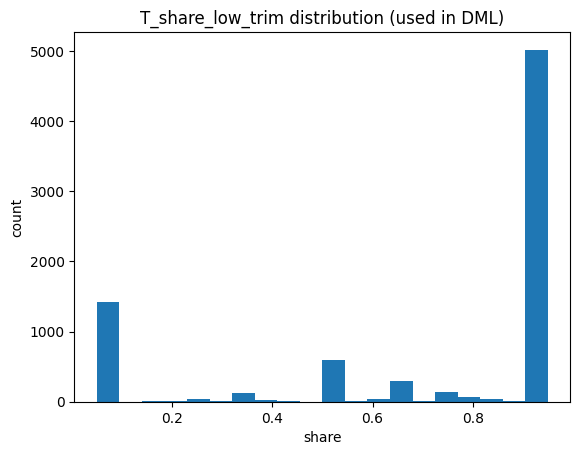

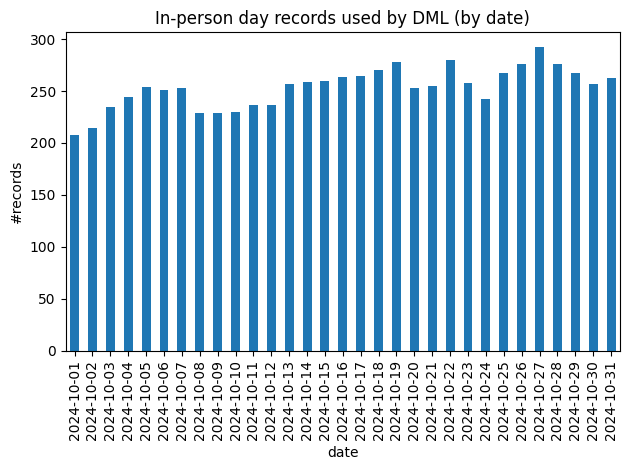

In [20]:
plt.figure()
plt.hist(sub[T_col], bins=20)
plt.title(f"{T_col} distribution (used in DML)")
plt.xlabel("share"); plt.ylabel("count")
plt.show()

plt.figure()
sub["_date"].dt.date.value_counts().sort_index().plot(kind="bar")
plt.title("In-person day records used by DML (by date)")
plt.xlabel("date"); plt.ylabel("#records")
plt.tight_layout(); plt.show()
